In [1]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
"""
test_images : it contains the list of np.arrays (RGB images) compatible with plt.show

"""

test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]


In [3]:
def list_images(images, cols = 2, rows = 4, cmap=None):
    
    """
    output : it will list out the sample images.
    
        Parameters:
            images: List of np.arrays compatible with plt.imshow.
            cols (Default = 2): Number of columns in the figure.
            rows (Default = 4): Number of rows in the figure.
            cmap (Default = None): Used to display gray images.
            
    """
    
    plt.figure(figsize=(12, 15))
    
    index = 1
    for image in images:
        
        plt.subplot(rows, cols, index)
        index = index + 1
        
        #Use gray scale color map if there is only one channel
        if len(image.shape) == 2:
            cmap = 'gray'
        else:
            cmap = cmap
        
        plt.imshow(image, cmap = cmap)
        
        # remove the label along x-axis and y-axis
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout(pad=0, h_pad=3, w_pad=3)
    plt.show()

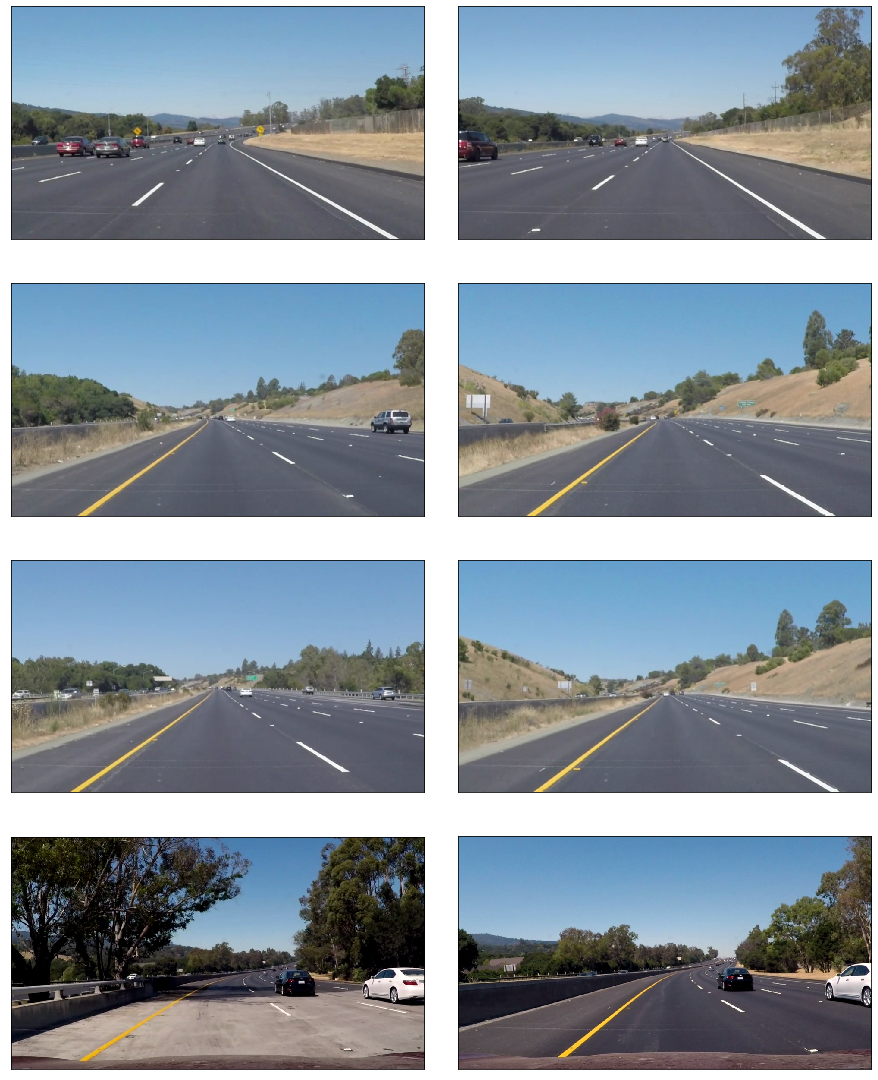

In [4]:
list_images(test_images)

In [5]:
def convert_to_hsl(image):
    
    """
    output: it returns the image converted to HSL
    
    Parameters:
        image: An np.array compatible with plt.imshow.
            
    """
    
    hsl_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    return hsl_image

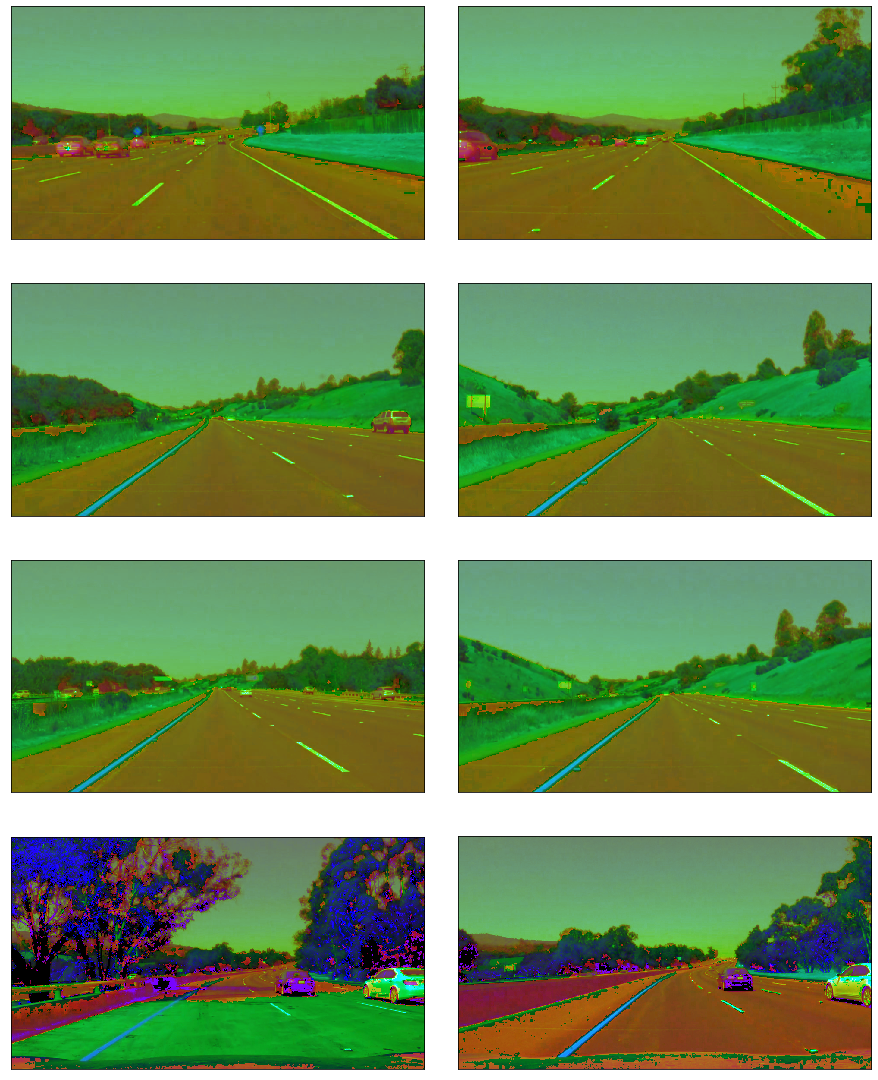

In [6]:
"""
HSL_images: it is list HSL images compatible with plt.show.

"""

HSL_images = list(map(convert_to_hsl, test_images))
list_images(HSL_images)

In [7]:
def HSL_color_selection(image):
    
    """
    output : Apply color selection to the HSL images to blackout everything except for white and yellow lane lines.
    Parameters:
        image: An np.array compatible with plt.imshow.
            
    """
    #Convert the input image to HSL
    converted_image = convert_to_hsl(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

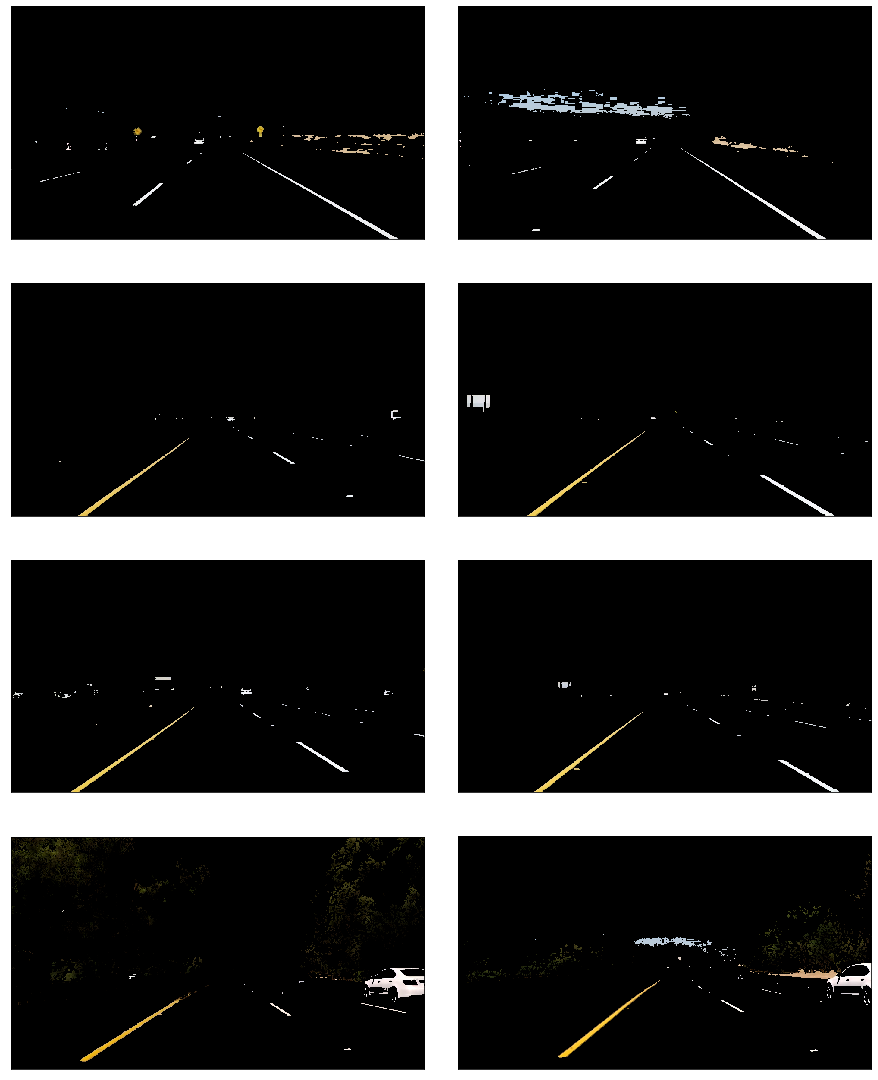

In [8]:
list_images(list(map(HSL_color_selection, test_images)))

In [9]:
"""
HSL_masked_images:  it is list np.arrays (HSL images) in which all the colors are 
                    masked except WHITE & YELLOW color because Lane Lines are mostly
                    yellow or white in color
"""
HSL_masked_images = list(map(HSL_color_selection, test_images))


In [10]:
def convert_to_gray(image):
    """
    output: Convert images to gray scale.
    
    Parameters:
        image: An np.array compatible with plt.imshow.
        
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    return gray_image

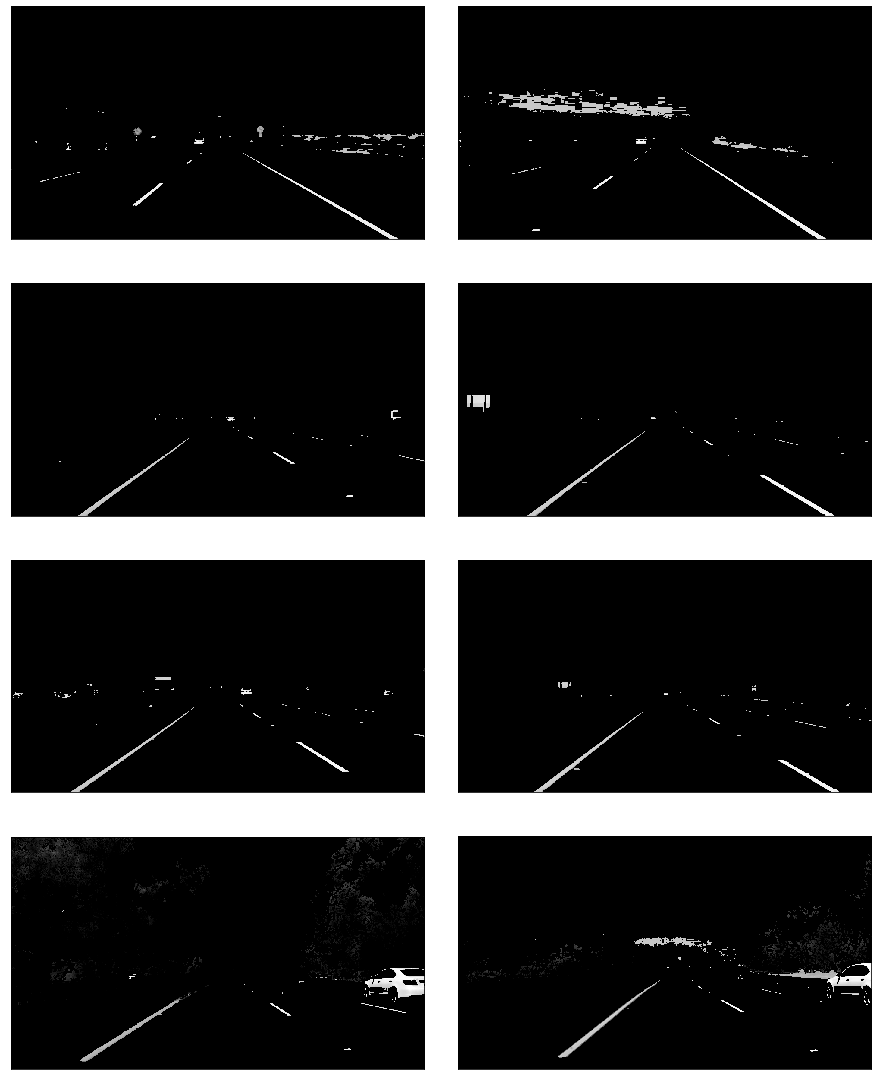

In [11]:
"""
gray_images: it list of np.arrays (GRAY images)

"""

gray_images = list(map(convert_to_gray, HSL_masked_images))
list_images(gray_images)

In [12]:
def gaussian_smoothing(image, kernel_size = 13):
    
    """"
    
    output: Apply Gaussian filter to the input image and return the blur images.
        Parameters:
            image: An np.array compatible with plt.imshow.
            kernel_size (Default = 13): The size of the Gaussian kernel will affect the performance of the detector.
            It must be an odd number (3, 5, 7, ...).
            
    """
    
    smooth_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return smooth_image

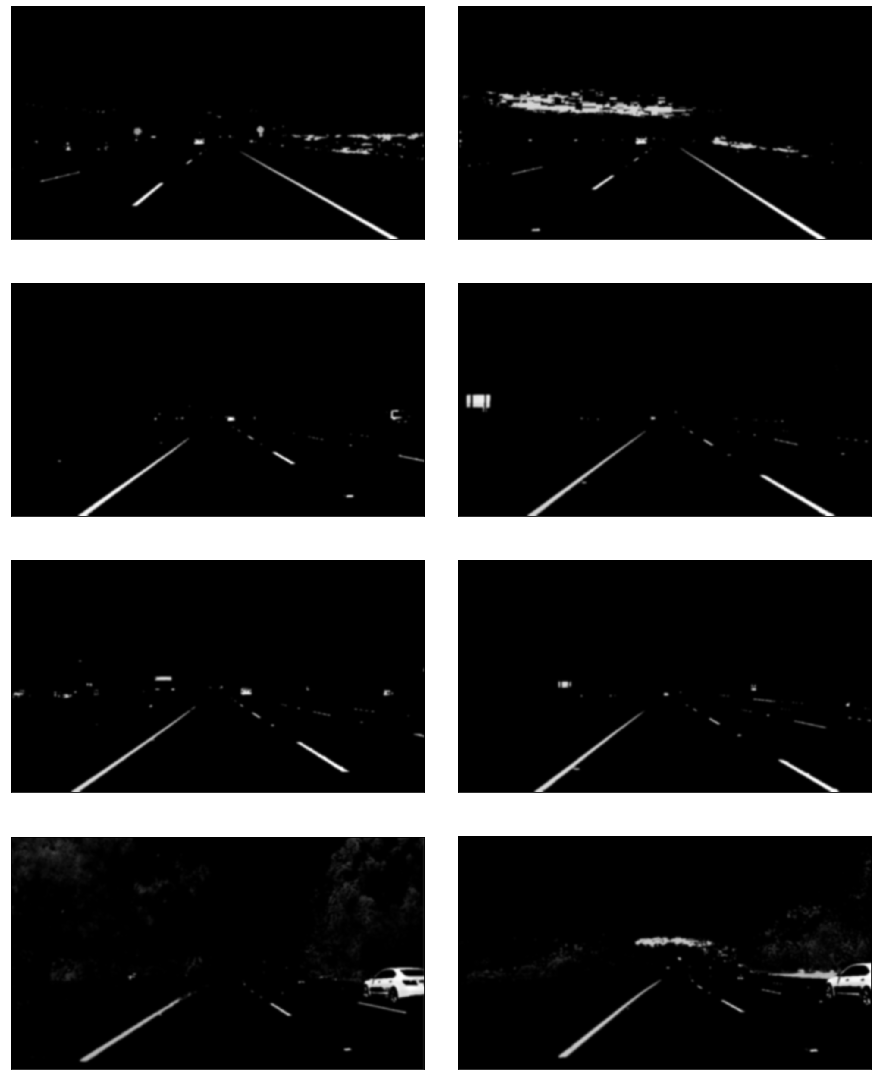

In [13]:
"""
smooth_images: it is list of np.arrays (smoothen images) from which noises has been filtered out.

"""

smooth_images = list(map(gaussian_smoothing, gray_images))
list_images(smooth_images)

In [14]:
def canny_edge_detector(image, low_threshold = 50, high_threshold = 150):
    
    """
    Apply Canny Edge Detection algorithm to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            low_threshold (Default = 50).
            high_threshold (Default = 150).
            
    """
    
    edge_detected_image = cv2.Canny(image, low_threshold, high_threshold)
    
    return edge_detected_image

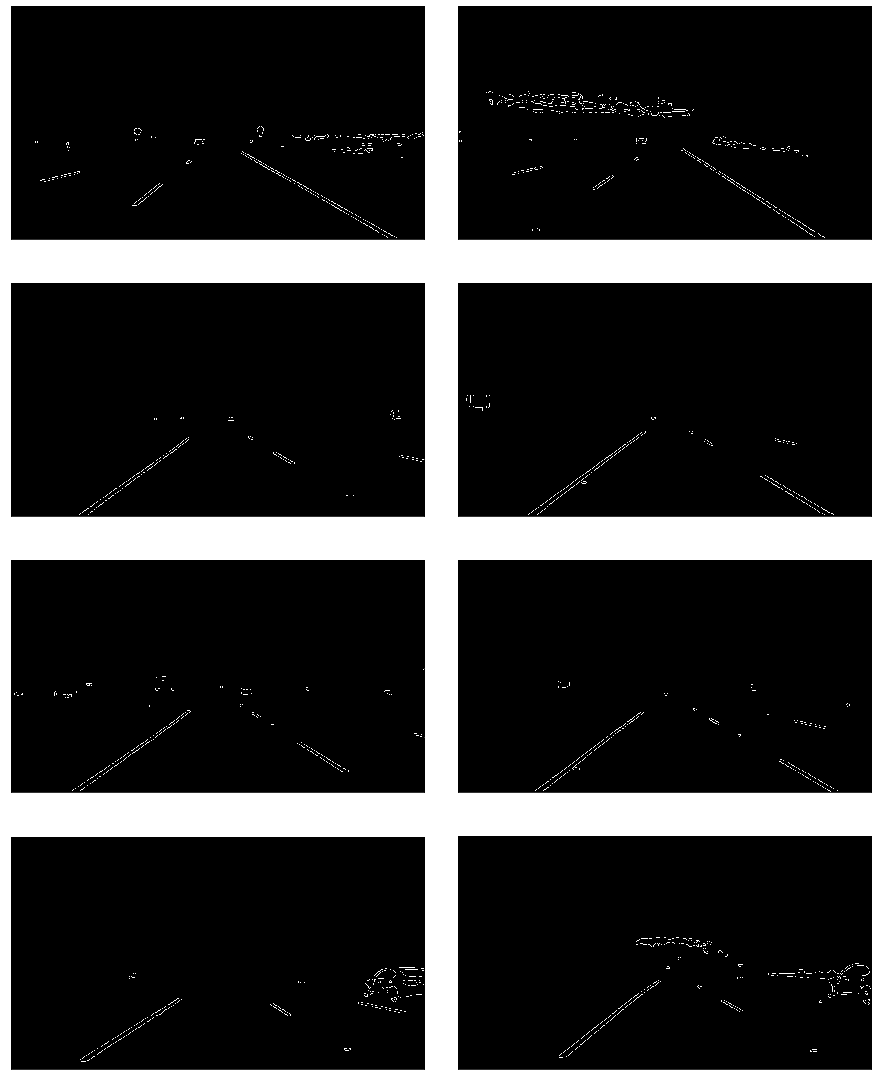

In [15]:
"""
edge_detected_imgaes: it is list of np.arrays (image) in which all the present edges are detected.

"""
edge_detected_images = list(map(canny_edge_detector, smooth_images))
list_images(edge_detected_images)

In [16]:
def region_of_interest(image):
    
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            
    """
    
    # black image
    mask = np.zeros_like(image) 
    
    # check the channel of image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    """
    ROI
    ---
    1. We can see from above images that out ROI is like a trapezium.
    2. We try to find the coordinates of all four vertices
   
    """
    
    # shape of the image
    # it return a tuple
    rows, cols = image.shape[:2]
    
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    
    """
    We fill ROI in the black image (calles mask) with white color.
    
    """
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    """
    And when we will perform bitwise_AND with edge detected image,
    only ROI will be in the output and remaining area will be black out
    
    """
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

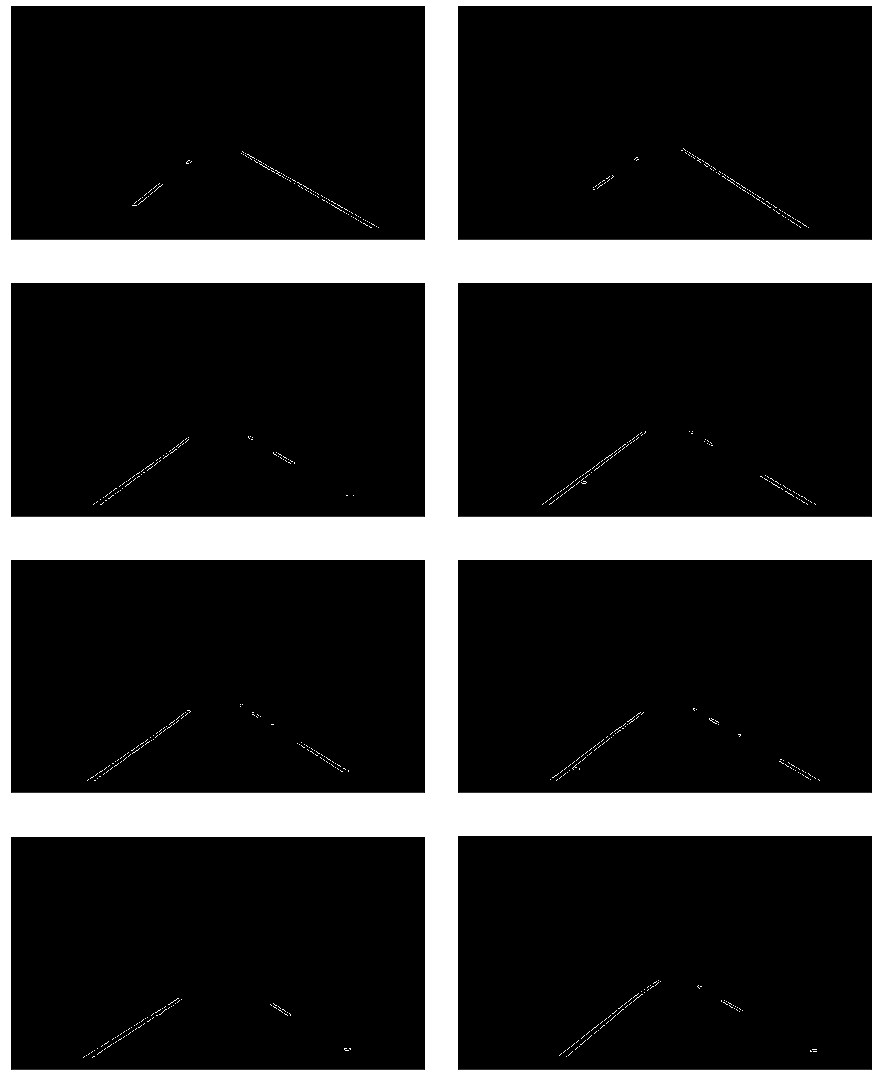

In [17]:
"""
masked_images: it is list np.arrays (image) in which all the areas of the image are suppressed except ROI.

"""

masked_images = list(map(region_of_interest, edge_detected_images))
list_images(masked_images)

In [18]:
def hough_transform(image):
    
    """
    output: return all the lines which are there in input image.
    
    Parameters:
        image: The output of a Canny transform.

    Parameters in HoughLinesP()
         rho: Distance resolution of the accumulator in pixels.
         theta: Angle resolution of the accumulator in radians.
         threshold: Only lines that are greater than threshold will be returned.
         minLineLength: Line segments shorter than that are rejected.
         maxLineGap: Maximum allowed gap between points on the same line to link them
            
    """
    
    rho = 1              
    theta = np.pi/180    
    threshold = 20       
    minLineLength = 20   
    maxLineGap = 300  
    
    return cv2.HoughLinesP(image, 
                           rho = rho, 
                           theta = theta, 
                           threshold = threshold,
                           minLineLength = minLineLength, 
                           maxLineGap = maxLineGap)

In [19]:
"""
hough_lines: it is a list of numpy array which containing all the lines of the present in that
             particular image.
             
"""
hough_lines = list(map(hough_transform, masked_images))


In [20]:
def draw_lines(image, lines, color = [0, 255, 0], thickness = 2):
    
    """
    Draw lines onto the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            lines: The lines we want to draw.
            color (Default = red): Line color.
            thickness (Default = 3): Line thickness.
    """
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
            
    return image

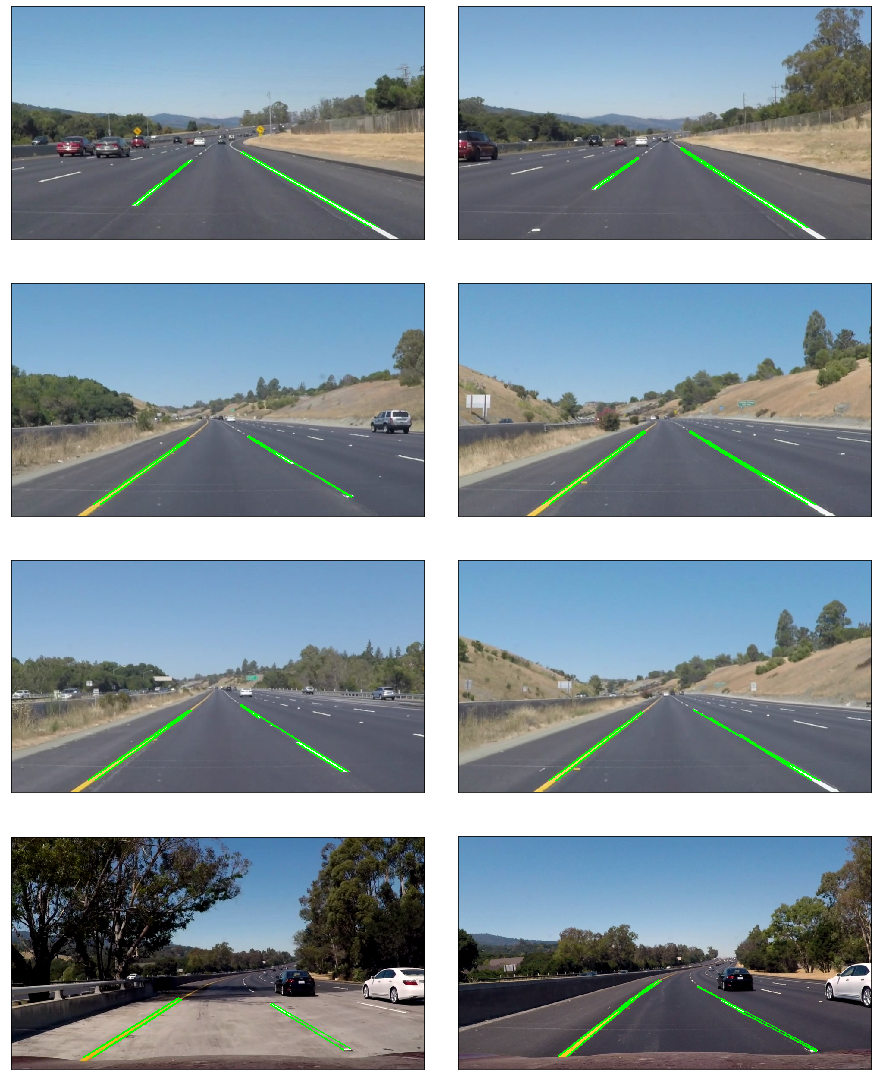

In [21]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

In [22]:
def average_slope_intercept(lines):
    
    """
    Find the slope and intercept of the left and right lanes of each image.
    
    Parameters:
        lines: The output lines from Hough Transform.
            
    """
    
    
    """
    left_lines: list containing tuple of (slope, intercept) of each left lines.
    left_weights: list containing tuple of (length,) of each left lines.
    
    right_lines, : similar to above.
    right_weights
    
    """
    left_lines    = []
    left_weights  = [] 
    right_lines   = [] 
    right_weights = [] 
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
                
    
    """
    left_lane: it contains the average slope and intercept of left lane.
    right_lane: similar to left lane.
    
    """
    if len(left_weights) > 0:
        left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)
    else:
        left_lane = None
    
    if len(right_weights) > 0:
        right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights)
    else:
        left_lane = None
    
    
    return left_lane, right_lane

In [23]:
def pixel_points(y1, y2, line):
    
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
    if line is None:
        return None
    
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

In [39]:
def lane_lines(image, lines):
    
    """
    Create full lenght lines from pixel points.
    
    Parameters:
        image: The input test image.
        lines: The output lines from Hough Transform.
        
    """
    
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.65
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    
    return left_line, right_line

    

In [40]:
def draw_lane_lines(image, lines, color=[0, 255, 0], thickness=12):
    
    """
    Draw lines onto the input image.
    
    Parameters:
        image: The input test image.
        lines: The output lines from Hough Transform.
        color (Default = red): Line color.
        thickness (Default = 12): Line thickness.
        
    """
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)
             


In [41]:
def draw_polly(image, bottom_left, top_left, top_right, bottom_right):
    
    # black image
    mask = np.zeros_like(image)
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    
    """
    We fill ROI in the black image (calles mask) with white color.
    
    """
    cv2.fillPoly(mask, vertices, (0, 255, 0))
    
    """
    And when we will perform bitwise_AND with edge detected image,
    only ROI will be in the output and remaining area will be black out
    
    """
    masked_image = cv2.bitwise_and(image, mask)
    
    return cv2.addWeighted(image, 1.0, masked_image, 1.0, 0.0)
     

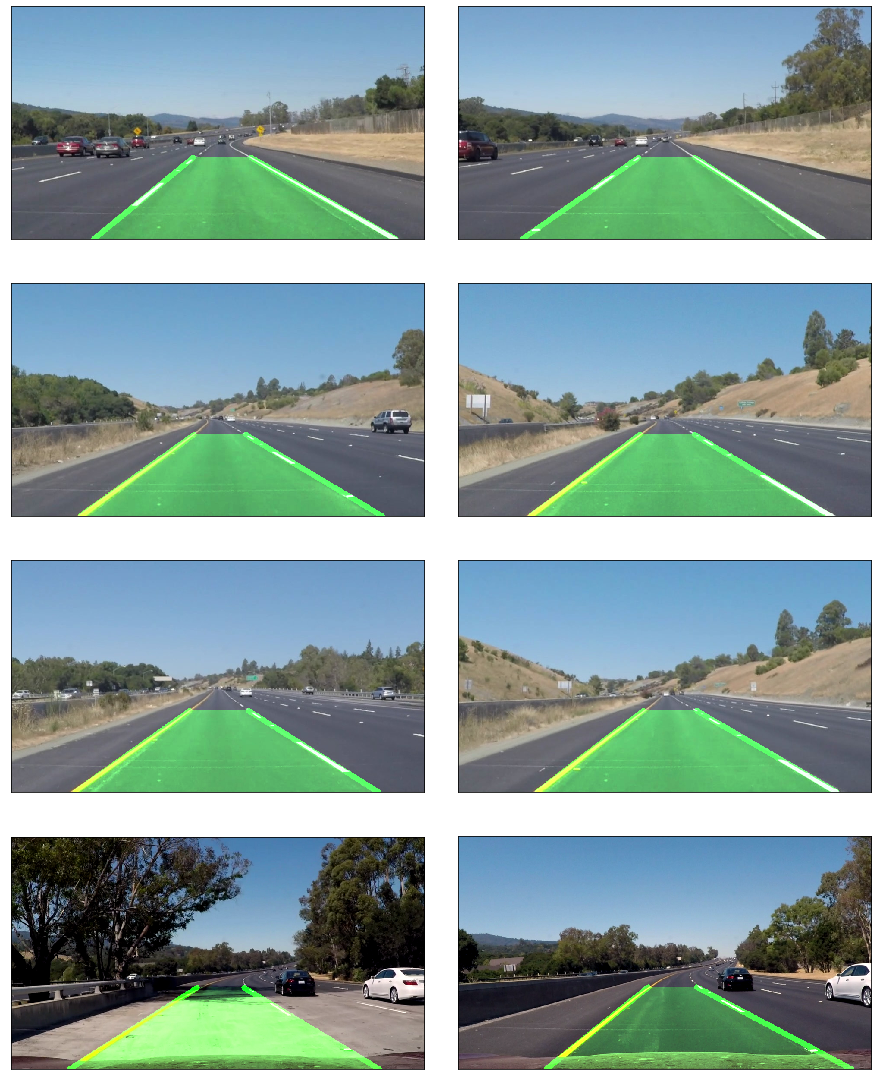

In [42]:
lane_images = []
for image, lines in zip(test_images, hough_lines):
    
    # draw line on lane line
    left_line, right_line = lane_lines(image, lines)
    line_on_image = draw_lane_lines(image, (left_line, right_line))

    #draw between lane line
    lane_images.append(draw_polly(line_on_image, left_line[0], left_line[1], right_line[1], right_line[0]))


list_images(lane_images)

In [43]:
#Import everything needed to edit/save/watch video clips
from moviepy import *
from IPython.display import HTML
from IPython.display import Image

In [44]:
def frame_processor(image):
    """
    Process the input frame to detect lane lines.
        Parameters:
            image: Single video frame.
    """
    color_select = HSL_color_selection(image)
    gray         = convert_to_gray(color_select)
    smooth       = gaussian_smoothing(gray)
    edges        = canny_edge_detector(smooth)
    region       = region_of_interest(edges)
    hough        = hough_transform(region)
    left_line, right_line = lane_lines(image, hough)
    line_on_image = draw_lane_lines(image, (left_line, right_line))
    result       = draw_polly(line_on_image, left_line[0], left_line[1], right_line[1], right_line[0])
    
    
    return result 

In [45]:
def process_video(test_video, output_video):
    """
    Read input video stream and produce a video file with detected lane lines.
        Parameters:
            test_video: Input video.
            output_video: A video file with detected lane lines.
    """
    input_video = VideoFileClip(os.path.join('input_videos', test_video), audio=False)
    processed = input_video.fl_image(frame_processor)
    processed.write_videofile(os.path.join('processed_videos', output_video), audio=False)

In [46]:
%time process_video('solidWhiteRight.mp4', 'solidWhiteRight_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("processed_videos\solidWhiteRight_output.mp4"))

Moviepy - Building video processed_videos\solidWhiteRight_output.mp4.
Moviepy - Writing video processed_videos\solidWhiteRight_output.mp4



Moviepy - Done !
Moviepy - video ready processed_videos\solidWhiteRight_output.mp4
Wall time: 10.1 s


In [47]:
%time process_video('solidYellowLeft.mp4', 'solidYellowLeft_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("processed_videos\solidYellowLeft_output.mp4"))

Moviepy - Building video processed_videos\solidYellowLeft_output.mp4.
Moviepy - Writing video processed_videos\solidYellowLeft_output.mp4



Moviepy - Done !
Moviepy - video ready processed_videos\solidYellowLeft_output.mp4
Wall time: 25.8 s


In [48]:
%time process_video('challenge.mp4', 'challenge_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("processed_videos\challenge_output.mp4"))

Moviepy - Building video processed_videos\challenge_output.mp4.
Moviepy - Writing video processed_videos\challenge_output.mp4



Moviepy - Done !
Moviepy - video ready processed_videos\challenge_output.mp4
Wall time: 18.9 s


In [50]:
%time process_video('project_video.mp4', 'project_video_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("processed_videos\project_video_output.mp4"))

Moviepy - Building video processed_videos\project_video_output.mp4.
Moviepy - Writing video processed_videos\project_video_output.mp4



Moviepy - Done !
Moviepy - video ready processed_videos\project_video_output.mp4
Wall time: 52.1 s
